## Examples of Variational Inference

We use variational methods to

-  Choose a class of approximating distributions
-  Find the best approximation to the true posterior

Variational inference minimizes the Kullback-Leibler divergence from an approximating, $\color{purple}{q(\theta)}$ distribution to the posterior dis
tribution (target distribution), $\color{red}{p(\theta\ |\ \mathcal{D})}$: 

$\mathbb{KL}(\color{purple}{q(\theta)} \parallel \color{red}{p(\theta\ |\ \mathcal{D})}) = -\mathbb{E}_q\left(\log\left(\frac{\color{red}{p(\theta\ |\ \mathcal{D})}}{\color{purple}{q(\theta)}}\right)\right)$

### Minimizing KL using the ELBO

Minimizing KL is equivalent to maximizing the Evidence Lower BOund (ELBO):

$\mathbb{KL}(\color{purple}{q(\theta)} \parallel \color{red}{p(\theta\ |\ \mathcal{D})}) = -(\underbrace{\mathbb{E}_q(\log \color{blue}{p(\mathcal{D}, \theta))} - \mathbb{E}_q(\color{purple}{\log q(\theta)})}_{\color{orange}{\textrm{ELBO}}}) - \log \color{green}{p(\mathcal{D})}$

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions import draw_values
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
import scipy as sp
import scipy.stats as st
import seaborn as sns
from theano import shared, tensor as tt

In [2]:
# For reproducibility

SEED = 12345 

np.random.seed(SEED)

### Variational Inference Example

Find the Gaussian with uncorrelated variables that minimizes the Kullback-Leibler divergence with a full-rank covariance Gaussian distribution.

We will approximate the target Gaussian with one that minimizes the ELBO with mean field assumptions so that the variables (e.g., parameters or $\theta$) are uncorrelated.

$q(\theta) = \left\{\left.N\left(\begin{pmatrix} \mu_{\theta_1} \\ \mu_{\theta_2} \end{pmatrix},
                              \begin{pmatrix} \sigma_{\theta_1}^2 & 0 \\ 0 & \sigma_{\theta_2}^2\end{pmatrix}\ \right|\ 
                       \mu_{\theta_1}, \mu_{\theta_2} \in \mathbb{R}^2, \sigma_{\theta_1}, \sigma_{\theta_2} > 0\right)\right\}$
                       
For these Gaussian the Kullback-Lieber divergence is given by 

$D_{KL}(q||p) = \frac{1}{2}\left[\log\frac{|\Sigma_p|}{|\Sigma_q|} - k + (\boldsymbol{\mu_q}-\boldsymbol{\mu_p})^T\Sigma_p^{-1}(\boldsymbol{\mu_q}-\boldsymbol{\mu_p}) + tr\left\{\Sigma_p^{-1}\Sigma_q\right\}\right]$

### Mean field Assumption
Assumes the variational distribution factors can be decomposed into disjoint, independent components. So, $q(\theta_1, \ldots, \theta_n) = q(\theta_1)  q(\theta_2) \cdots q(\theta_{n-1})q(\theta_n)$

With this assumption the variational approximation can be found by coordinate ascent (like Gibbs, except optimization not sampling). 

Let 
$q_{-i}(\boldsymbol{\theta})
    = q(\theta_1) \cdots q(\theta_{i - 1})\ q(\theta_{i + 1}) \cdots q(\theta_n)$

Then

$\begin{align*}
q(\theta_i)
    & \propto \exp\left(\mathbb{E}_{q_{-i}}(\log(\mathcal{D}, \boldsymbol{\theta}))\right)
\end{align*}$


Suppose suppose the target distibution is a two dimensional Gaussian with an arbitrary mean, $\mu$, and with a variance-covariance matrix with $\sigma_{11} = 1.0,   \sigma_{22} = \sqrt{0.5}$, and the correlation, $\rho = 0.75$ Show the variational approximation that minimizes the Kullback-Liebler divergence with this Gaussian using the mean field assumption. Explain the shape of this approximation.

In [6]:
# Replace ? with the correct values or expressions

SIGMA_theta1 = 1
SIGMA_theta2 = np.sqrt(0.5)
CORR_COEF = 0.75

true_cov = np.array([[SIGMA_theta1**2, CORR_COEF * SIGMA_theta1 * SIGMA_theta2],
                     [CORR_COEF * SIGMA_theta1 * SIGMA_theta2, SIGMA_theta2**2]])

true_precision = np.linalg.inv(true_cov)

approx_sigma_theta1, approx_sigma_theta2 = 1. / np.sqrt(np.diag(true_precision))

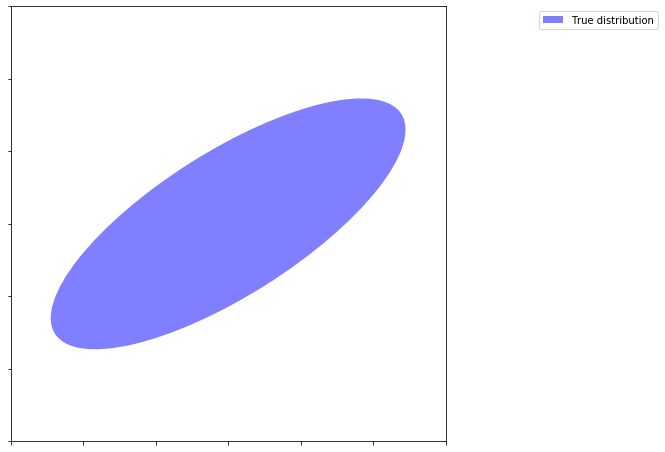

In [7]:
fig, ax  = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal');


var, U = np.linalg.eig(true_cov)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

e = Ellipse(np.zeros(2), 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor('blue')
e.set_zorder(10);
ax.add_artist(e);

ax.set_xlim(-3, 3);
ax.set_xticklabels([]);

ax.set_ylim(-3, 3);
ax.set_yticklabels([]);

rect = plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.5)
ax.legend([rect],
          ['True distribution'],
          bbox_to_anchor=(1.5, 1.));

They were independent under the mean filed assumption.

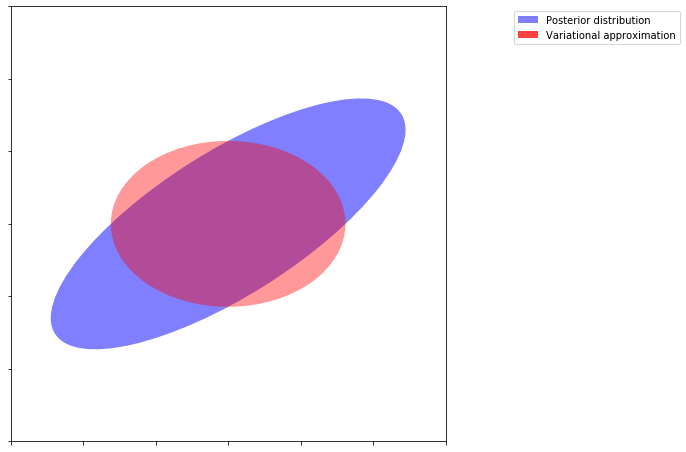

In [9]:
# Find the appoximating Gaussian with uncorrelated variables

vi_e = Ellipse(np.zeros(2), 2 * np.sqrt(5.991) * approx_sigma_theta1, 
               2 * np.sqrt(5.991) * approx_sigma_theta2)
vi_e.set_alpha(0.4)
vi_e.set_facecolor('red')
vi_e.set_zorder(11);
ax.add_artist(vi_e);

vi_rect = plt.Rectangle((0, 0), 1, 1, fc='red', alpha=0.75)

ax.legend([rect, vi_rect],
          ['Posterior distribution',
           'Variational approximation'],
          bbox_to_anchor=(1.55, 1.));
fig

### Beta-binomial Model Example

 Suppose we have the following results from   tests of infections in the sore throats of our patients: $\{0, 1, 0,  1, 1,  0, 0, 0, 0, 0\}$, where $1$ indicates an infection  and $0$ indicates no infection. We assume a uniform prior for the probability of infection. Show the plot of the true posterior and use the ADVI optimization to obtain the variational approximation of the posterior. Overlay the plot of this approximation on the true posterior. 

In [25]:
# Enter the data
x_beta_binomial = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [26]:
# Create the model

with pm.Model() as beta_binomial_model:
    p_beta_binomial = pm.Uniform('p', 0., 1.)
    x_obs = pm.Bernoulli('x', p_beta_binomial,
                         observed=x_beta_binomial)

### Transforming the Beta for Variational Inference

The optimization method we will use requires an unconstrained distribution. The Beta distribution is contrained so we will transform it.

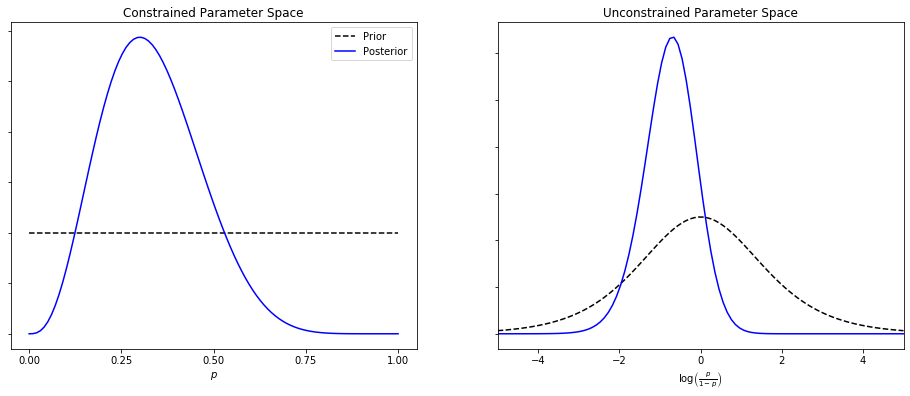

In [27]:
# plot the transformed (unconstrained) parameters
fig, (const_ax, trans_ax) = plt.subplots(ncols=2, figsize=(16, 6))

prior = sp.stats.uniform(0, 1)
posterior = sp.stats.beta(1 + x_beta_binomial.sum(),
                          1 + (1 - x_beta_binomial).sum())

# constrained distribution plots
const_x = np.linspace(0, 1, 100)
const_ax.plot(const_x, prior.pdf(const_x),
              '--', c='k', label='Prior');

def logit_trans_pdf(pdf, x):
    x_logit = sp.special.logit(x)
    return pdf(x_logit) / (x * (1 - x))

const_ax.plot(const_x, posterior.pdf(const_x),
              c='blue', label='Posterior');

const_ax.set_xticks(np.linspace(0, 1, 5));
const_ax.set_xlabel(r'$p$');
const_ax.set_yticklabels([]);
const_ax.set_title('Constrained Parameter Space');
const_ax.legend(loc=1);

# unconstrained distribution plots
def expit_trans_pdf(pdf, x):
    x_expit = sp.special.expit(x)
    return pdf(x_expit) * x_expit * (1 - x_expit)

trans_x = np.linspace(-5, 5, 100)
trans_ax.plot(trans_x, expit_trans_pdf(prior.pdf, trans_x),
              '--', c='k');
trans_ax.plot(trans_x, expit_trans_pdf(posterior.pdf, trans_x),
              c='blue');

trans_ax.set_xlim(trans_x.min(), trans_x.max());
trans_ax.set_xlabel(r'$\log\left(\frac{p}{1 - p}\right)$');
trans_ax.set_yticklabels([]);
trans_ax.set_title('Unconstrained Parameter Space');

## Automating Variational Inference in Python

Maximize ELBO using gradient ascent instead of coordinate ascent. 
Tensor libraries calculate ELBO gradients automatically. PYMC3 uses the tensor library Theano. 

### Automatic Differentiation Variational Inference (__[ADVI](https://arxiv.org/abs/1603.00788)__)

- Only applicable to differentiable probability models
- Transform constrained parameters to be unconstrained
- Approximate the posterior for unconstrained parameters with mean field Gaussian

In [28]:
# Obtain the variational approximation to the beta

with beta_binomial_model:
    approx = pm.fit(50000, method = 'advi', random_seed = SEED)

Finished [100%]: Average Loss = 7.1941


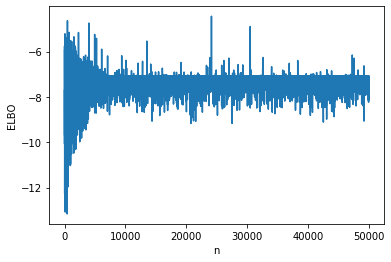

In [29]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

# Can also use - 
# plt.plot(approx.hist);

In [30]:
# The approximation parameters

advi_bb_mu = approx.mean.eval()
advi_bb_std = approx.std.eval()
advi_bb_dist = sp.stats.norm(advi_bb_mu, advi_bb_std)

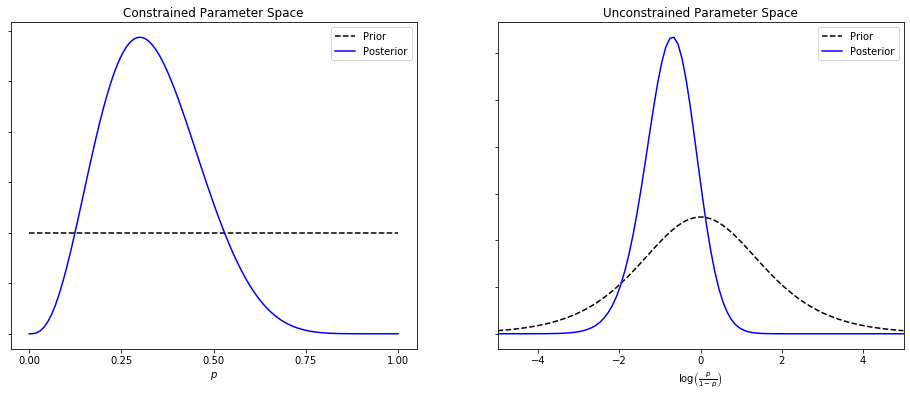

In [31]:

# plot the transformed (unconstrained) parameters
fig, (const_ax, trans_ax) = plt.subplots(ncols=2, figsize=(16, 6))

prior = sp.stats.uniform(0, 1)
posterior = sp.stats.beta(1 + x_beta_binomial.sum(),
                          1 + (1 - x_beta_binomial).sum())

# constrained distribution plots
const_x = np.linspace(0, 1, 100)
const_ax.plot(const_x, prior.pdf(const_x),
              '--', c='k', label='Prior');

def logit_trans_pdf(pdf, x):
    x_logit = sp.special.logit(x)
    return pdf(x_logit) / (x * (1 - x))

const_ax.plot(const_x, posterior.pdf(const_x),
              c='blue', label='Posterior');

const_ax.set_xticks(np.linspace(0, 1, 5));
const_ax.set_xlabel(r'$p$');
const_ax.set_yticklabels([]);
const_ax.set_title('Constrained Parameter Space');
const_ax.legend(loc=1);

# unconstrained distribution plots
def expit_trans_pdf(pdf, x):
    x_expit = sp.special.expit(x)
    return pdf(x_expit) * x_expit * (1 - x_expit)

trans_x = np.linspace(-5, 5, 100)
trans_ax.plot(trans_x, expit_trans_pdf(prior.pdf, trans_x),
              '--', c='k', label = "Prior");
trans_ax.plot(trans_x, expit_trans_pdf(posterior.pdf, trans_x),
              c='blue', label = "Posterior");

trans_ax.set_xlim(trans_x.min(), trans_x.max());
trans_ax.set_xlabel(r'$\log\left(\frac{p}{1 - p}\right)$');
trans_ax.set_yticklabels([]);
trans_ax.set_title('Unconstrained Parameter Space');
trans_ax.legend(loc=1);

# plot the ADVI gaussian approximation to the unconstrained posterior
#trans_ax.plot(trans_x, advi_bb_dist.pdf(trans_x),
#              c='red', label='Variational approximation');
#fig

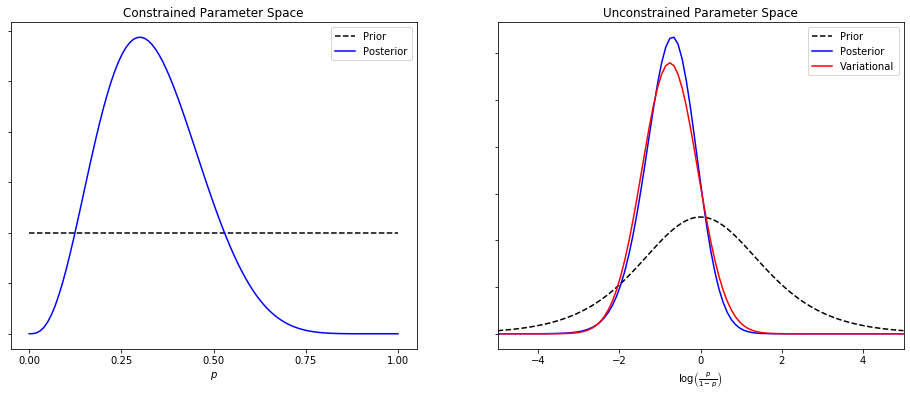

In [32]:
# plot the ADVI gaussian approximation to the unconstrained posterior
trans_ax.plot(trans_x, advi_bb_dist.pdf(trans_x),
              c='red', label='Variational');
trans_ax.legend(loc=1);

fig

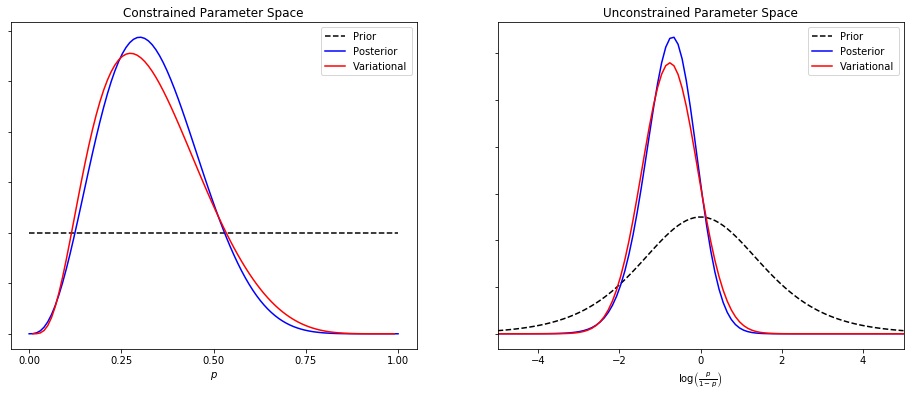

In [33]:
# plot the ADVI approximation to the true posterior
const_ax.plot(const_x, logit_trans_pdf(advi_bb_dist.pdf, const_x),
              c='red', label='Variational');
const_ax.legend(loc = 1)
fig

Never going to converge, close is good enough to scale


In [23]:
# Find the Laplace approximation
# 

with pm.Model() as normal_aproximation:
    p = ?
    w = ?
    mean_q = ?
    std_q = ?
mean_q['p'], std_q

SyntaxError: invalid syntax (<ipython-input-23-c0f74ac29e57>, line 5)

In [ ]:
# Graphically display the model used for Laplace approximation
pm.model_to_graphviz(normal_aproximation)